In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")

In [3]:
def get_agg_df_w_baseline(archetype, agg_type="mean", return_raw=False):
    def _add_drug_length(df):
        df["drug_length"] = -1
        df.loc[df["drug_type"]=="DP", "drug_length"] = 28
        df.loc[np.logical_or(df["drug_type"]=="ASAQ", df["drug_type"]=="SPAQ"), "drug_length"] = 14
        
    scenario_df = pd.read_csv("../scenario_master_list.csv")
    scenario_df = scenario_df[scenario_df["archetype"]==archetype].reset_index(drop=True)

    if archetype == "Sahel":
        df = pd.read_csv("endpoints_312b5201-609d-eb11-a2ce-c4346bcb1550.csv")
        df2 = pd.read_csv("endpoints_44bed067-43a2-eb11-a2ce-c4346bcb1550.csv") # SMC with DP
        df = pd.concat([df,df2])
    elif archetype == "Southern":
        df = pd.read_csv("endpoints_a71e7b31-559d-eb11-a2ce-c4346bcb1550.csv")
        df2 = pd.read_csv("endpoints_b7cd3df7-24a2-eb11-a2ce-c4346bcb1550.csv") #extra ITN scenario
        df = pd.concat([df,df2])
    elif archetype == "Central":
        df = pd.read_csv("endpoints_53be112d-06b8-eb11-a2e3-c4346bcb7275.csv")

    # df cleaning
    df["out_of_school_rate"] = np.round(df["out_of_school_rate"],2)
    _add_drug_length(df)
    df.fillna({"smc_on": False,
                "smc_age_range": "default",
                "ivermectin": False,
                "primaquine": False}, inplace=True)
    
    df_baseline = df[df["scenario_number"]==30].groupby("burnin_approx_pfpr2_10").agg(agg_type).reset_index()
#     df_allout = df[df["scenario_number"]==27].groupby("burnin_approx_pfpr2_10").agg("mean").reset_index()

    df_agg = df.groupby(["burnin_approx_pfpr2_10", "scenario_number"]).agg(agg_type).reset_index().merge(scenario_df, on="scenario_number", suffixes=("","_DUPLICATED"))
    df_agg["out_of_school_rate"] = np.round(df_agg["out_of_school_rate"],2)

    df_agg_w_baseline = df_agg.merge(df_baseline, on="burnin_approx_pfpr2_10", suffixes=["","_BASELINE"], how="left")
    
    if return_raw:
        df_w_baseline = df.merge(df_baseline, on="burnin_approx_pfpr2_10", suffixes=["","_BASELINE"], how="left")
        
        return df_agg_w_baseline, df_w_baseline
    else:
        return df_agg_w_baseline

In [4]:
intervention_name_list = {}
intervention_name_list["Sahel"] = [
    "SPAQ_IST_term",
    "SPAQ_IST_month",
    "SPAQ_IPT_term",
    "SPAQ_IPT_month",
    "DP_IST_term",
    "DP_IST_month",
    "DP_IPT_term",
    "DP_IPT_month",
    "DP_IPT_day"
]

#ordered by impact
intervention_name_list["Southern"] = [
#     "No IPTsc; increase ITNs",
#     "No IPTsc; cover 90% of u5s each term",
    "ASAQ_IST_term",
    "ASAQ_IPT_term",
    "DP_IST_term",
    "ASAQ_IST_month",
    "DP_IPT_term",
    "DP_IST_month",
    "ASAQ_IPT_month",
    "DP_IPT_month",
    "DP_IPT_day"
]

#ordered by impact
intervention_name_list["Central"] = [
#     "No IPTsc; increase ITNs",
#     "No IPTsc; cover 90% of u5s each term",
    "ASAQ_IST_term",
    "ASAQ_IPT_term",
    "DP_IST_term",
    "ASAQ_IST_month",
    "DP_IPT_term",
    "DP_IST_month",
    "ASAQ_IPT_month",
    "DP_IPT_month",
    "DP_IPT_day"
]

# bar.loc[bar["scenario_number"]==31, "intervention_name"] = "No IPTsc; increase ITNs"
# bar.loc[bar["scenario_number"]==32, "intervention_name"] = "No IPTsc; cover 90\% of u5s each term"

c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

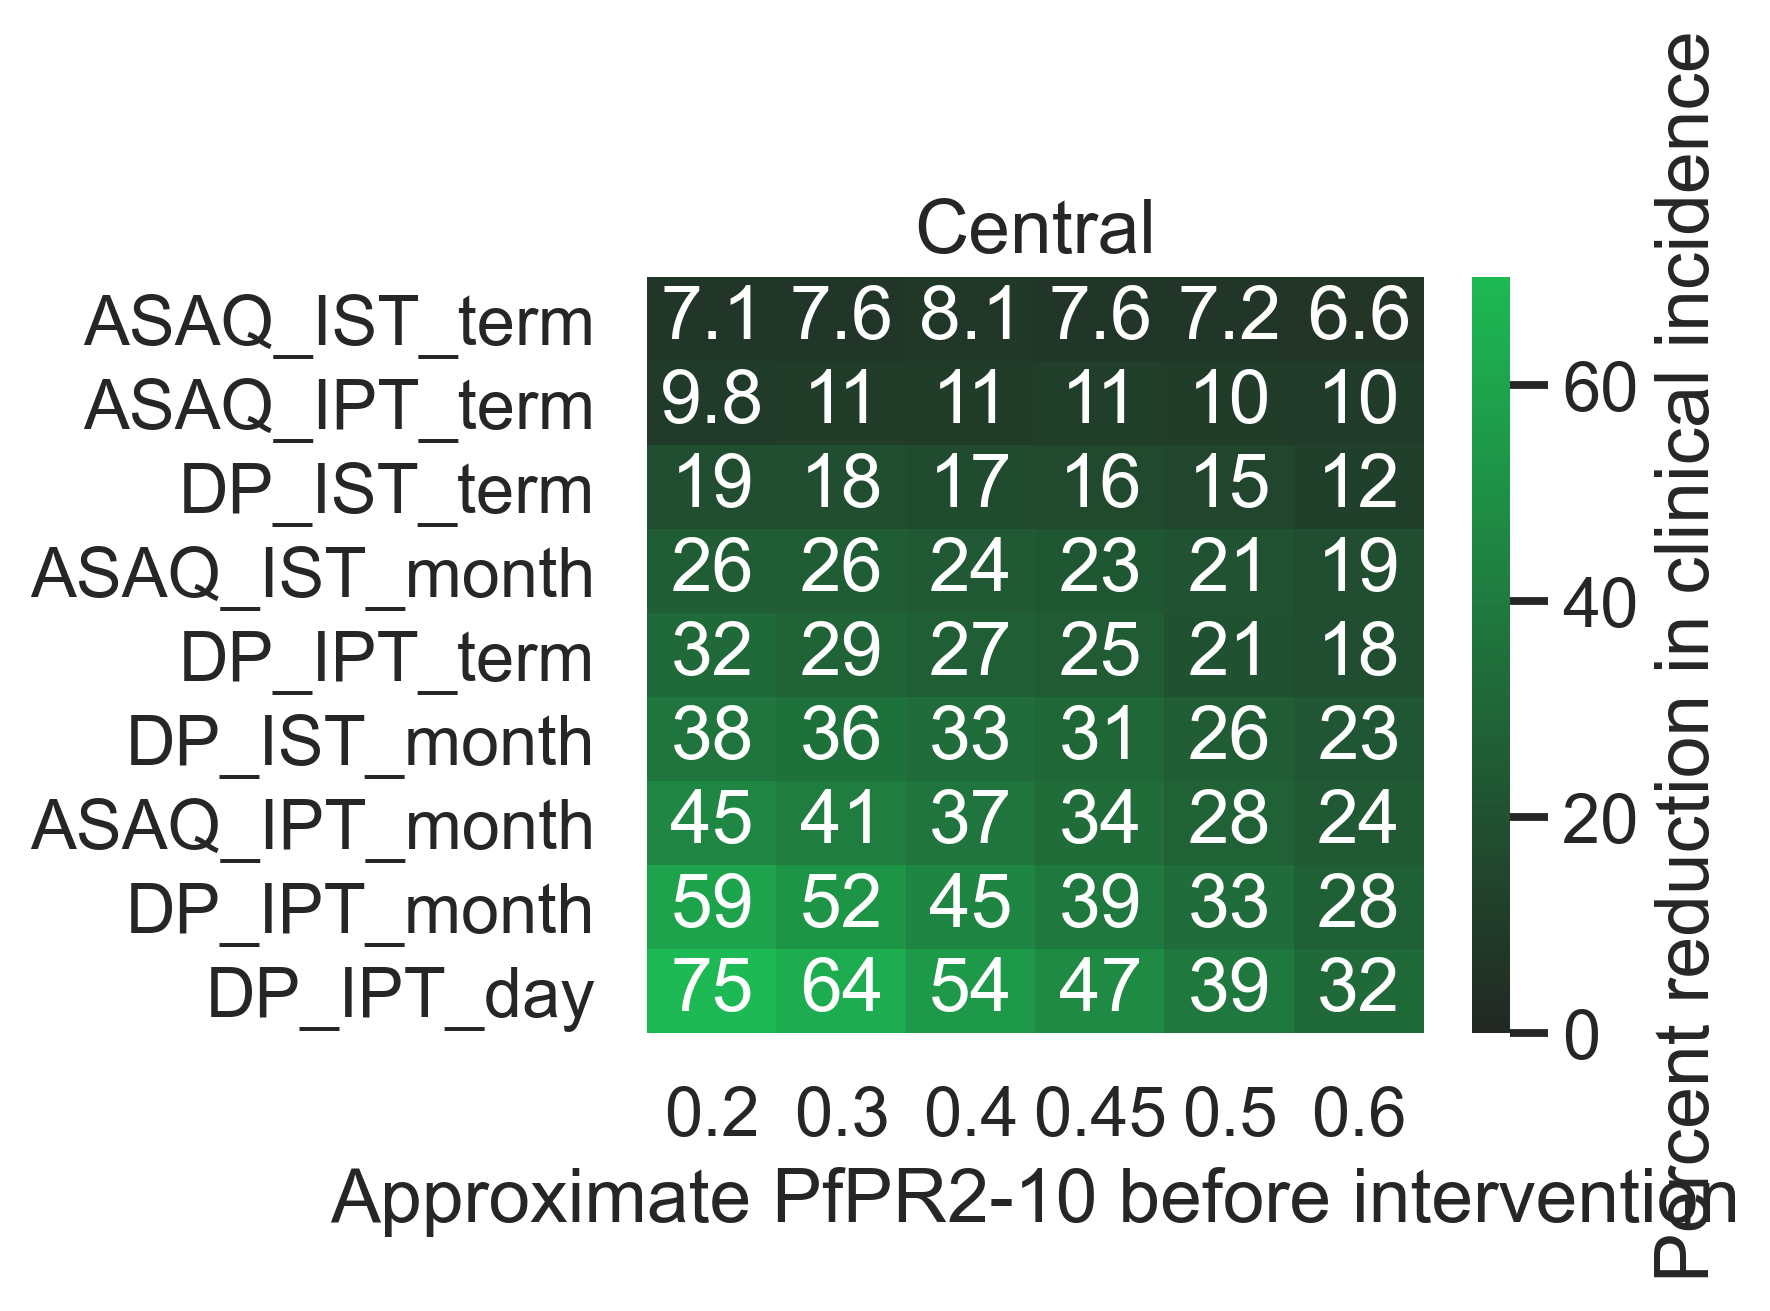

In [5]:
plt.figure(dpi=300)
archetype="Central"
foo = get_agg_df_w_baseline(archetype)
# bar = foo[foo["out_of_school_rate"]==0.15]
bar = foo[np.in1d(foo["scenario_number"], [1,4,7,10,13,16,19,22,27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, 
            vmin=0, vmax=70, cmap=sns.dark_palette("#1DB954", reverse=False, as_cmap=True))
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)
plt.tight_layout()

# plt.savefig("figures/2021-04-13_dryrun/southern_heatmap.pdf")

c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

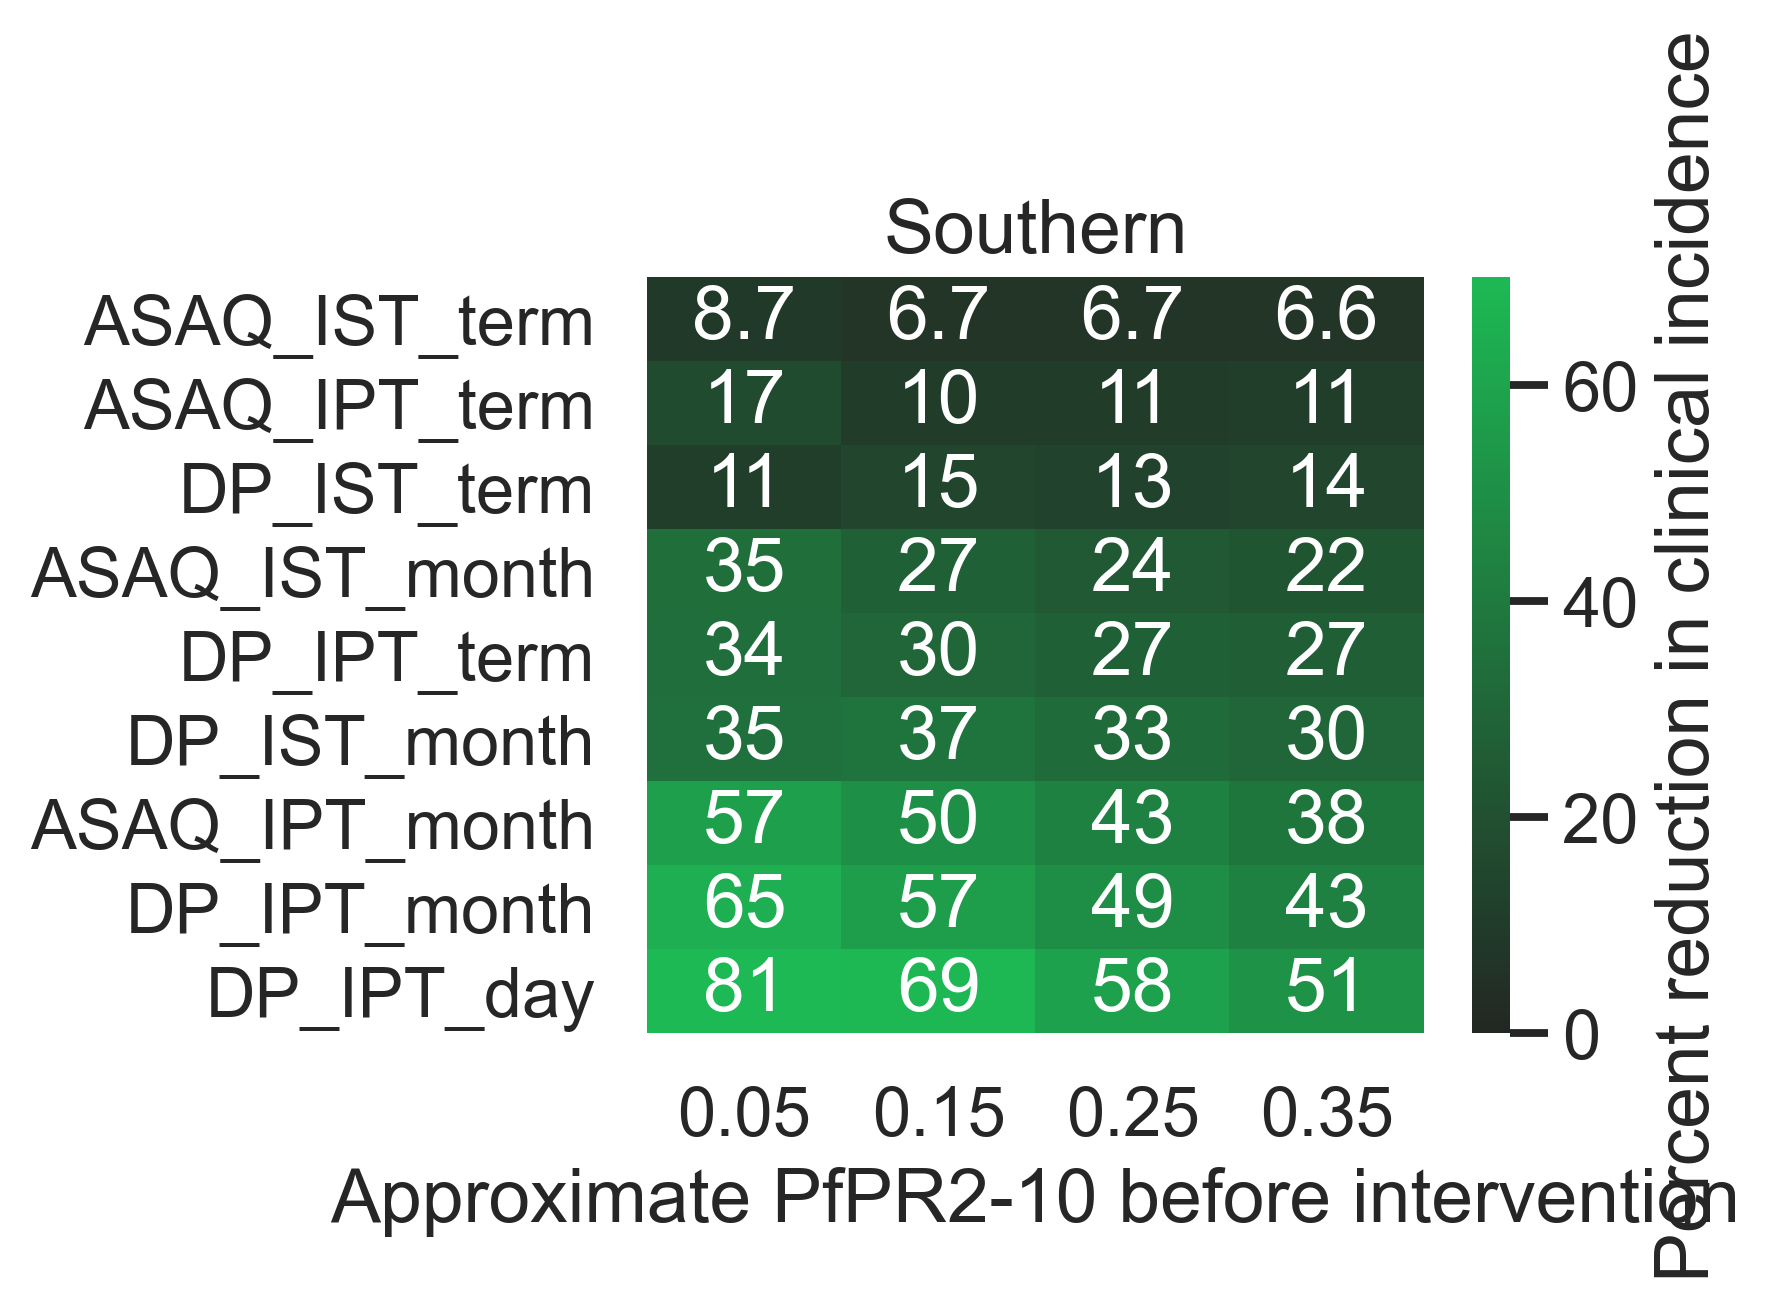

In [6]:
plt.figure(dpi=300)
archetype="Southern"
foo = get_agg_df_w_baseline(archetype)
# bar = foo[foo["out_of_school_rate"]==0.15]
bar = foo[np.in1d(foo["scenario_number"], [1,4,7,10,13,16,19,22,27])]
bar["Clinical Incidence Reduction"] = 100*(bar["clinical_incidence_all_BASELINE"]-bar["clinical_incidence_all"])/bar["clinical_incidence_all_BASELINE"]
bar["intervention_name"] = bar["drug_type"]+"_"+bar["screen_type"]+"_"+bar["interval"]

bar['intervention_name'] = pd.Categorical(bar['intervention_name'], intervention_name_list[archetype])
bar.sort_values(by="intervention_name")

bar = bar.pivot("intervention_name", "burnin_approx_pfpr2_10", "Clinical Incidence Reduction")
sns.heatmap(bar, annot=True,cbar_kws={'label': 'Percent reduction in clinical incidence'}, 
            vmin=0, vmax=70, cmap=sns.dark_palette("#1DB954", reverse=False, as_cmap=True))
plt.ylabel(None)
plt.xlabel("Approximate PfPR2-10 before intervention")
plt.title(archetype)
plt.tight_layout()

# plt.savefig("figures/2021-04-13_dryrun/southern_heatmap.pdf")

In [19]:
def compare_across_archetypes(scenario_number=13):
    
    df_list = []
    for archetype in ["Southern", "Sahel", "Central"]:
        df_agg, df = get_agg_df_w_baseline(archetype, return_raw=True)
        bar_agg = df_agg[df_agg["scenario_number"]==scenario_number]
        bar = df[df["scenario_number"]==scenario_number]
        
        bar_agg["archetype"] = archetype
        bar["archetype"] = archetype
        df_list.append(bar.copy())
        
    bar = pd.concat(df_list)
        
    bar["cir_adult"] = 100*(bar["clinical_incidence16_500_BASELINE"]-bar["clinical_incidence16_500"])/bar["clinical_incidence16_500_BASELINE"]
    bar["cir_sac"] = 100*(bar["clinical_incidence6_15_BASELINE"]-bar["clinical_incidence6_15"])/bar["clinical_incidence6_15_BASELINE"]
    bar["cir_u5"] = 100*(bar["clinical_incidence0_5_BASELINE"]-bar["clinical_incidence0_5"])/bar["clinical_incidence0_5_BASELINE"]
        
        
    def _agg_f(x):
        d = {}
        d['cir_adult_mean'] = x['cir_adult'].mean()
        d['cir_adult_std'] = x['cir_adult'].std()
        d['cir_sac_mean'] = x['cir_sac'].mean()
        d['cir_sac_std'] = x['cir_sac'].std()
        d['cir_u5_mean'] = x['cir_u5'].mean()
        d['cir_u5_std'] = x['cir_u5'].std()
        
        return pd.Series(d, index=['cir_adult_mean', 'cir_adult_std', 'cir_sac_mean', 'cir_sac_std', 'cir_u5_mean', 'cir_u5_std'])

    t = bar.groupby(["archetype", "burnin_approx_pfpr2_10","pfpr2_10_BASELINE"]).apply(_agg_f).reset_index()
#     bar_agg_with_err = bar.groupby(["burnin_approx_pfpr2_10"]).agg("std").reset_index()
    
        
    return t
    
        

In [20]:
t = compare_across_archetypes()

c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\jsuresh\venv\default_venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [9]:
for a, sdf in bar.groupby("archetype"):
    plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_adult"], label=a)
    plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_u5"], label=a)
#     plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_sac"], label=a)
    
    
plt.ylim(0,70)
plt.legend()

KeyError: 'archetype'

In [ ]:
t = compare_across_archetypes()

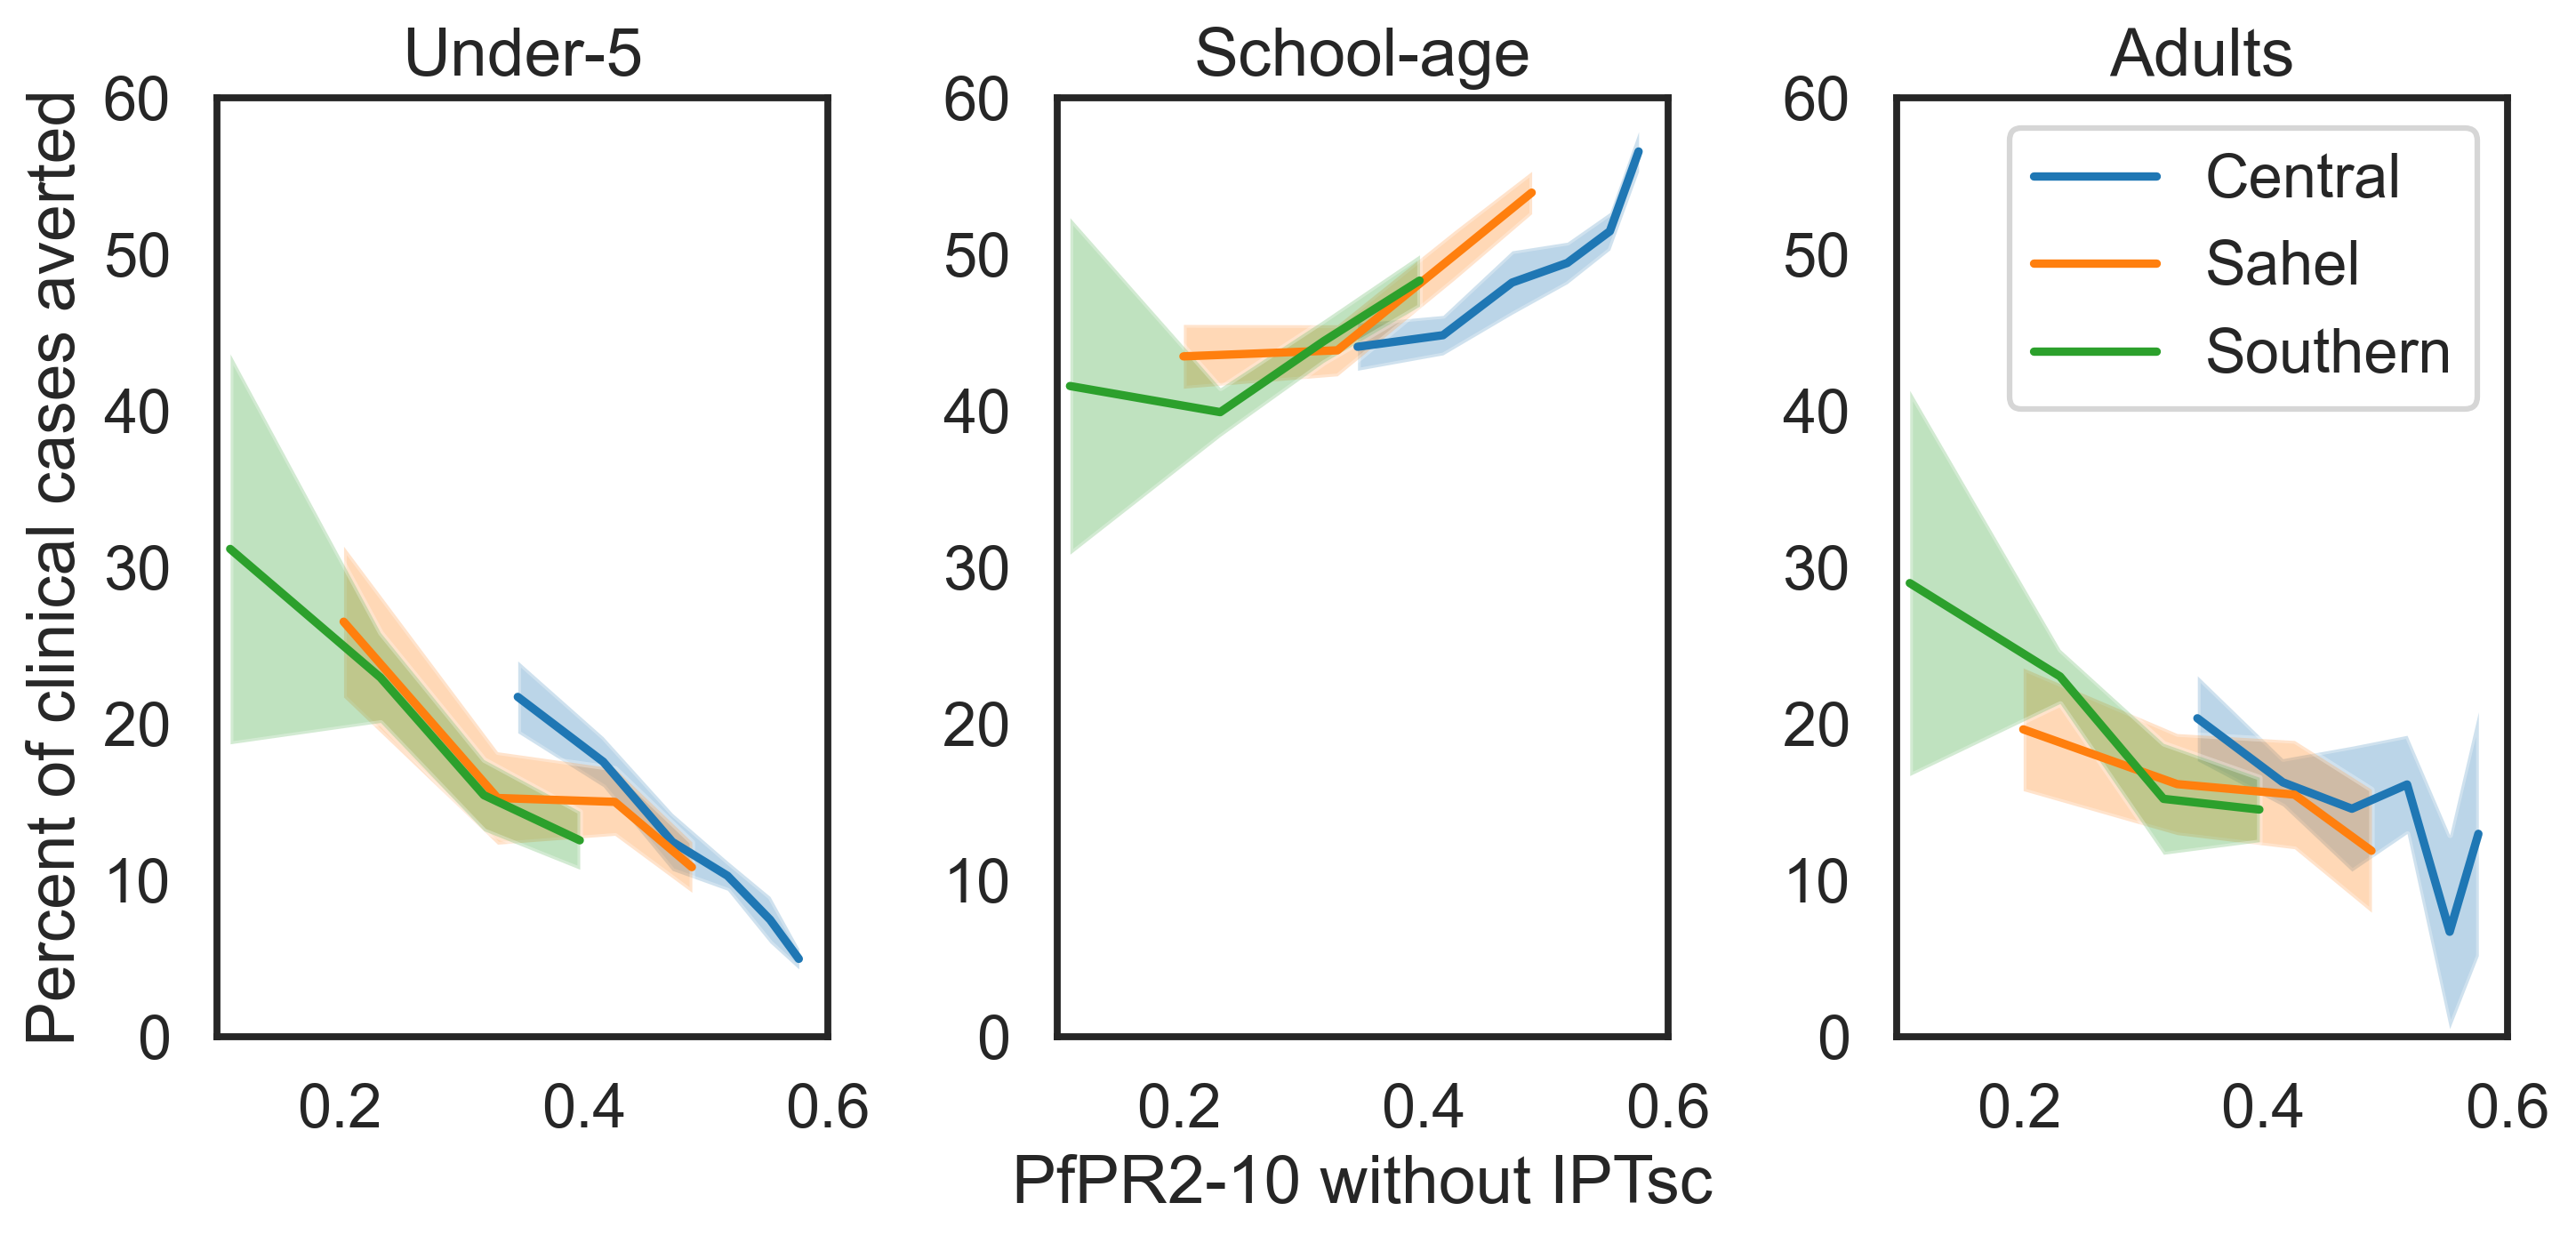

In [11]:
# Plot that compares impact across transmission archetypes:
plt.figure(dpi=300, figsize=(10,5))
plt.subplot(131)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_u5_mean"], label=a)
    plt.fill_between(sdf["pfpr2_10_BASELINE"], sdf["cir_u5_mean"]-sdf["cir_u5_std"], sdf["cir_u5_mean"]+sdf["cir_u5_std"], label=a, alpha=0.3)
plt.title("Under-5")
plt.ylim([0,60])
plt.ylabel("Percent of clinical cases averted")
plt.xlim([.10,.60])
    
plt.subplot(132)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_sac_mean"], label=a)
    plt.fill_between(sdf["pfpr2_10_BASELINE"], sdf["cir_sac_mean"]-sdf["cir_sac_std"], sdf["cir_sac_mean"]+sdf["cir_sac_std"], label=a, alpha=0.3)
plt.title("School-age")
plt.ylim([0,60])
plt.xlabel("PfPR2-10 without IPTsc")
plt.xlim([.10,.60])

plt.subplot(133)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["pfpr2_10_BASELINE"], sdf["cir_adult_mean"], label=a)
    plt.fill_between(sdf["pfpr2_10_BASELINE"], sdf["cir_adult_mean"]-sdf["cir_adult_std"], sdf["cir_adult_mean"]+sdf["cir_adult_std"],alpha=0.3)
plt.legend()
plt.title("Adults")
plt.ylim([0,60])
plt.xlim([.10,.60])

plt.tight_layout()

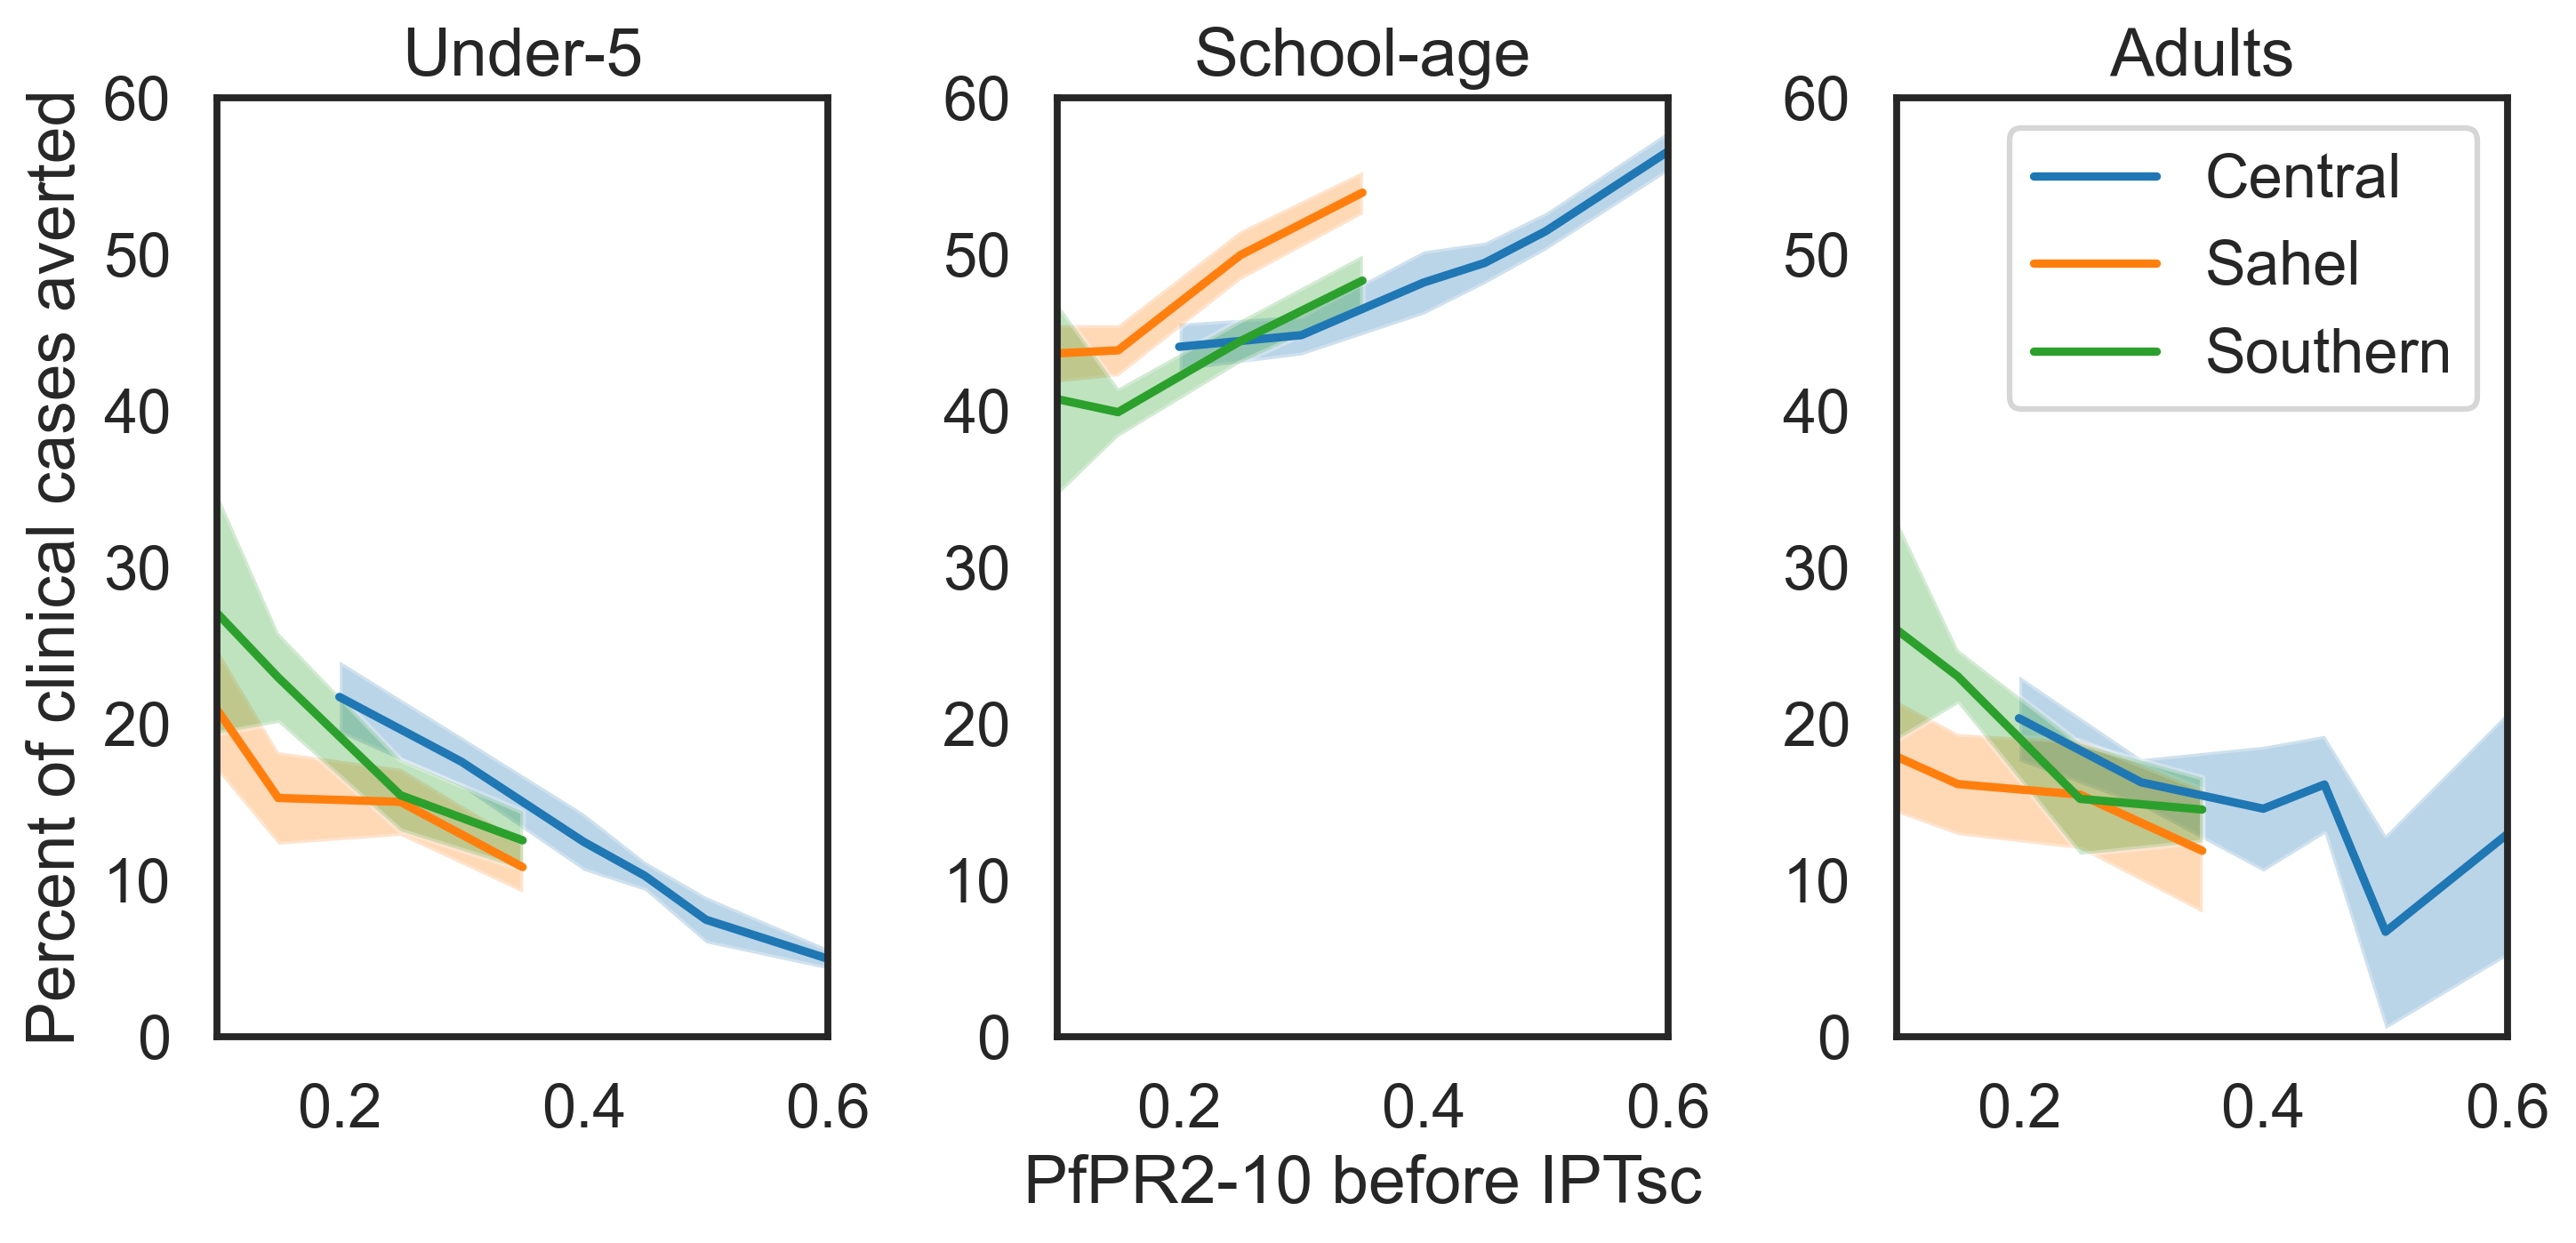

In [23]:
# Plot that compares impact across transmission archetypes:
plt.figure(dpi=300, figsize=(10,5))
plt.subplot(131)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["burnin_approx_pfpr2_10"], sdf["cir_u5_mean"], label=a)
    plt.fill_between(sdf["burnin_approx_pfpr2_10"], sdf["cir_u5_mean"]-sdf["cir_u5_std"], sdf["cir_u5_mean"]+sdf["cir_u5_std"], label=a, alpha=0.3)
plt.title("Under-5")
plt.ylim([0,60])
plt.ylabel("Percent of clinical cases averted")
plt.xlim([.10,.60])
    
plt.subplot(132)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["burnin_approx_pfpr2_10"], sdf["cir_sac_mean"], label=a)
    plt.fill_between(sdf["burnin_approx_pfpr2_10"], sdf["cir_sac_mean"]-sdf["cir_sac_std"], sdf["cir_sac_mean"]+sdf["cir_sac_std"], label=a, alpha=0.3)
plt.title("School-age")
plt.ylim([0,60])
plt.xlabel("PfPR2-10 before IPTsc")
plt.xlim([.10,.60])

plt.subplot(133)
for a, sdf in t.groupby("archetype"):
    plt.plot(sdf["burnin_approx_pfpr2_10"], sdf["cir_adult_mean"], label=a)
    plt.fill_between(sdf["burnin_approx_pfpr2_10"], sdf["cir_adult_mean"]-sdf["cir_adult_std"], sdf["cir_adult_mean"]+sdf["cir_adult_std"],alpha=0.3)
plt.legend()
plt.title("Adults")
plt.ylim([0,60])
plt.xlim([.10,.60])

plt.tight_layout()

## Same but with error bars

In [32]:
df_agg, df = get_agg_df_w_baseline("Central", return_raw=True)

,pfpr0_5,pfpr2_10,pfpr6_15,pfpr16_500,pfpr_all,clinical_incidence0_5,clinical_incidence2_10,clinical_incidence6_15,clinical_incidence16_500,clinical_incidence_all,...,smc_on_BASELINE,within_school_coverage_BASELINE,Received_Treatment_BASELINE,Received_Test_BASELINE,Received_Campaign_Drugs_BASELINE,Received_RCD_Drugs_BASELINE,Received_SMC_BASELINE,Received_Ivermectin_BASELINE,Received_Primaquine_BASELINE,drug_length_BASELINE
0,0.193889,0.232180,0.228461,0.178779,0.193606,2.857973,2.050562,0.731505,0.266093,0.895614,...,False,0.9,7801.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.314697,0.221260,0.098606,0.184752,0.189022,4.298203,2.296611,0.158043,0.108444,0.902125,...,False,0.9,9132.3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.051999,0.303298,0.532018,0.206315,0.252814,0.659033,1.698328,2.429814,0.140200,0.768875,...,False,0.9,9132.3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.407107,0.303262,0.166708,0.199116,0.230285,5.169947,2.812452,0.395334,0.071326,1.092619,...,False,0.9,9656.2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.320793,0.325713,0.283581,0.187861,0.235202,4.412935,2.811223,0.790700,0.119957,1.088104,...,False,0.9,9132.3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.440967,0.513008,0.497093,0.215170,0.321906,5.826253,4.076068,1.708772,0.076232,1.517071,...,False,0.9,9656.2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2276,0.301888,0.393176,0.420375,0.206544,0.274772,4.153616,3.281662,1.680098,0.195943,1.316286,...,False,0.9,8795.2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2277,0.140451,0.205835,0.252759,0.181360,0.190443,2.123083,2.307896,1.887821,0.425582,1.109880,...,False,0.9,6660.2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2278,0.471777,0.488780,0.433811,0.214893,0.318640,6.202595,3.613164,0.882227,0.055397,1.477776,...,False,0.9,11292.1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


# Compare incidence time series with/without IPT: